# Full fledge neural net with hyperparameter and droput

In [3]:
import numpy as np 

In [8]:
import numpy as np

class DeepNeuralNetwork:
    def __init__(self, input_size, output_size, hidden_size, epoches=1000, learning_rate=0.001,
                 dropout=0.5, hidden_layers=2, b1=0.9, b2=0.999):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.hidden_layers = hidden_layers
        self.epoches = epoches
        self.b1 = b1
        self.b2 = b2
        self.epsilon = 1e-8
        self.t = 1  # timestep for bias correction

        # Initialize weights and biases
        self.hidden_weights = [np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)]
        self.hidden_bias = [np.zeros((1, hidden_size))]

        for _ in range(hidden_layers - 1):
            self.hidden_weights.append(np.random.randn(hidden_size, hidden_size) * np.sqrt(2 / hidden_size))
            self.hidden_bias.append(np.zeros((1, hidden_size)))

        self.output_weight = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
        self.output_bias = np.zeros((1, output_size))

        self.mw = [np.zeros_like(w) for w in self.hidden_weights]
        self.vw = [np.zeros_like(w) for w in self.hidden_weights]
        self.mb = [np.zeros_like(b) for b in self.hidden_bias]
        self.vb = [np.zeros_like(b) for b in self.hidden_bias]

        self.mw_out = np.zeros_like(self.output_weight)
        self.vw_out = np.zeros_like(self.output_weight)
        self.mb_out = np.zeros_like(self.output_bias)
        self.vb_out = np.zeros_like(self.output_bias)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def derivative_sigmoid(self, z):
        s = self.sigmoid(z)
        return s * (1 - s)

    def Relu(self, z):
        return np.maximum(0, z)

    def derivative_relu(self, z):
        return (z > 0).astype(float)

    def compute_loss(self, preds, Y):
        preds = np.clip(preds, 1e-8, 1 - 1e-8)
        return -np.mean(Y * np.log(preds) + (1 - Y) * np.log(1 - preds))

    def Dropout(self, A):
        mask = np.random.rand(*A.shape) < self.dropout
        return (mask * A) / self.dropout

    def Adam(self, dw, db, l):

        self.mw[l] = self.b1 * self.mw[l] + (1 - self.b1) * dw
        self.vw[l] = self.b2 * self.vw[l] + (1 - self.b2) * (dw ** 2)

        mw_corr = self.mw[l] / (1 - self.b1 ** self.t)
        vw_corr = self.vw[l] / (1 - self.b2 ** self.t)

  
        self.mb[l] = self.b1 * self.mb[l] + (1 - self.b1) * db
        self.vb[l] = self.b2 * self.vb[l] + (1 - self.b2) * (db ** 2)

        mb_corr = self.mb[l] / (1 - self.b1 ** self.t)
        vb_corr = self.vb[l] / (1 - self.b2 ** self.t)


        W = mw_corr / (np.sqrt(vw_corr) + self.epsilon)
        B = mb_corr / (np.sqrt(vb_corr) + self.epsilon)
        return W, B

    def Adam_output(self, dw, db):
        self.mw_out = self.b1 * self.mw_out + (1 - self.b1) * dw
        self.vw_out = self.b2 * self.vw_out + (1 - self.b2) * (dw ** 2)

        mw_corr = self.mw_out / (1 - self.b1 ** self.t)
        vw_corr = self.vw_out / (1 - self.b2 ** self.t)

        self.mb_out = self.b1 * self.mb_out + (1 - self.b1) * db
        self.vb_out = self.b2 * self.vb_out + (1 - self.b2) * (db ** 2)

        mb_corr = self.mb_out / (1 - self.b1 ** self.t)
        vb_corr = self.vb_out / (1 - self.b2 ** self.t)

        W = mw_corr / (np.sqrt(vw_corr) + self.epsilon)
        B = mb_corr / (np.sqrt(vb_corr) + self.epsilon)
        return W, B

    def ForwardPropagation(self, X):
        self.Activations = [X]
        self.hidden_Z = []

        for l in range(self.hidden_layers):
            Z = np.dot(self.Activations[l], self.hidden_weights[l]) + self.hidden_bias[l]
            self.hidden_Z.append(Z)
            A = self.Relu(Z)
            A = self.Dropout(A)
            self.Activations.append(A)

        self.output_Z = np.dot(self.Activations[-1], self.output_weight) + self.output_bias
        self.output_A = self.sigmoid(self.output_Z)
        return self.output_A

    def BackPropagation(self, X, Y):
        m = X.shape[0]
        self.t += 1  

        error = self.output_A - Y
        Dwo = 1 / m * np.dot(self.Activations[-1].T, error)
        Dbo = 1 / m * np.sum(error, axis=0, keepdims=True)

        W_update, B_update = self.Adam_output(Dwo, Dbo)
        self.output_weight -= self.learning_rate * W_update
        self.output_bias -= self.learning_rate * B_update

        for l in reversed(range(self.hidden_layers)):
            da = np.dot(error, self.output_weight.T if l == self.hidden_layers - 1 else self.hidden_weights[l + 1].T)
            dz = da * self.derivative_relu(self.hidden_Z[l])
            dw = 1 / m * np.dot(self.Activations[l].T, dz)
            db = 1 / m * np.sum(dz, axis=0, keepdims=True)
            error = dz

            W, B = self.Adam(dw, db, l)
            self.hidden_weights[l] -= self.learning_rate * W
            self.hidden_bias[l] -= self.learning_rate * B

    def fit(self, X, Y):
        Y = np.array(Y).reshape(-1, 1)
        for epoch in range(self.epoches):
            preds_F = self.ForwardPropagation(X)
            loss = self.compute_loss(preds_F, Y)
            print(f"epoch: {epoch + 1}, loss: {loss:.6f}")
            self.BackPropagation(X, Y)

    def predict(self, X):
        return (self.ForwardPropagation(X) > 0.5).astype(int)


In [16]:
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import pandas as pd 
dataset = pd.read_csv("../BankNote_Authentication.csv")
dataset.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [17]:
Y = np.array(dataset['class']).reshape(-1,1)
X = np.array(dataset.drop(columns=['class']))
X_train,X_test,Y_train,Y_test = train_test_split(X,Y)

print(Y_train.shape)

(1029, 1)


In [27]:
# X = np.array([[0,0],[0,1],[1,0],[1,1]])
# Y = np.array([0,0,0,1])
model = DeepNeuralNetwork(
    input_size=4,
    output_size=1,
    hidden_size=16,
    epoches=1000,
    learning_rate=0.001,
    dropout=0.8,
    hidden_layers=4
)

model.fit(X_train,Y_train)
preds = model.predict(X_test)

epoch: 1, loss: 2.699763
epoch: 2, loss: 2.970510
epoch: 3, loss: 2.569685
epoch: 4, loss: 2.819074
epoch: 5, loss: 2.444407
epoch: 6, loss: 2.376190
epoch: 7, loss: 2.449560
epoch: 8, loss: 2.430240
epoch: 9, loss: 2.306749
epoch: 10, loss: 2.340564
epoch: 11, loss: 2.187684
epoch: 12, loss: 1.998306
epoch: 13, loss: 2.012799
epoch: 14, loss: 2.202371
epoch: 15, loss: 2.028654
epoch: 16, loss: 2.069457
epoch: 17, loss: 2.059302
epoch: 18, loss: 1.958949
epoch: 19, loss: 1.954255
epoch: 20, loss: 1.960761
epoch: 21, loss: 1.855412
epoch: 22, loss: 1.852337
epoch: 23, loss: 1.813594
epoch: 24, loss: 1.653063
epoch: 25, loss: 1.950143
epoch: 26, loss: 1.820264
epoch: 27, loss: 1.622089
epoch: 28, loss: 1.665053
epoch: 29, loss: 1.843990
epoch: 30, loss: 1.620025
epoch: 31, loss: 1.684038
epoch: 32, loss: 1.509626
epoch: 33, loss: 1.590536
epoch: 34, loss: 1.662309
epoch: 35, loss: 1.498426
epoch: 36, loss: 1.693833
epoch: 37, loss: 1.632916
epoch: 38, loss: 1.335387
epoch: 39, loss: 1.58

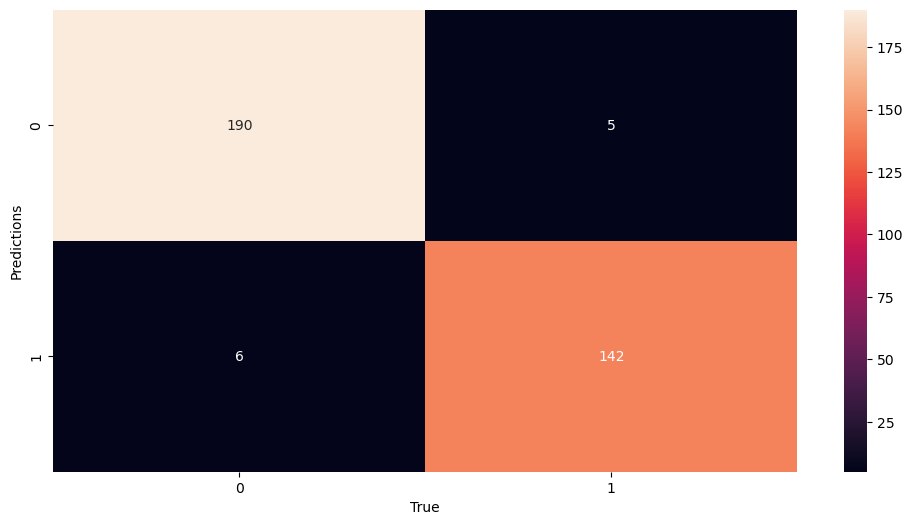

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       195
           1       0.97      0.96      0.96       148

    accuracy                           0.97       343
   macro avg       0.97      0.97      0.97       343
weighted avg       0.97      0.97      0.97       343



In [30]:
from sklearn.metrics import classification_report
cmf = confusion_matrix(Y_test,preds)

plt.figure(figsize=(12,6))
sns.heatmap(cmf,annot=True,fmt='d')
plt.xlabel("True")
plt.ylabel("Predictions")
plt.show()
print(classification_report(Y_test,preds))

In [ ]:
print(np.random.randint())

[3 3 2 1 3]
